Computers see images using pixels. Pixels in images are usually related. For example, a certain group of pixels may signify an edge in an image or some other pattern. Convolutions use this to help identify images.

A convolution multiplies a matrix of pixels with a filter matrix or ‘kernel’ and sums up the multiplication values. Then the convolution slides over to the next pixel and repeats the same process until all the image pixels have been covered

In [19]:
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [20]:
#identify images path for future use
PATH = "/Users/My_Drive/Desktop/amliNet/Data"
#load the csv file to load targets
df = pd.read_csv(PATH + "/train.csv")
df = df.sample(1000)

In [21]:
# csv file has different image path, we change to math to our directory

def edit_urls(url):
    pieces = url.split('/')
    newurl=''
    for i, piece in enumerate(pieces):
        if i>0:
            newurl += '/' + piece
        elif i==0:
            newurl += PATH
    return newurl

Now let’s take a look at one of the images in our dataset to see what we are working with. We will plot the first image in our dataset and check its size using the ‘shape’ function.

/Users/My_Drive/Desktop/amliNet/Data/train/patient01199/study1/view2_lateral.jpg


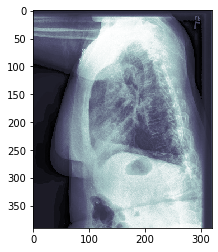

(320, 390)

In [36]:
#testing
tester_url = edit_urls(df.iloc[0]['Path'])
print( tester_url )
xray = Image.open(tester_url)
plt.imshow(xray, cmap="bone")
plt.show()

xray.size

In [5]:
#Change the path for all images
df["Path"] = df["Path"].apply(edit_urls)

Our dataset has a lot of NaN values, that are described as "no finding", we will fill them with zeros. Also, there are "m

In [6]:
#identify what features will be used for model training
outcomes = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'
]
#fill missing values with zeros, and assign all unsertain values (-1) to positive (1)
df[outcomes] = df[outcomes].fillna(0)
df[outcomes] = df[outcomes].replace(-1, 1)

In [7]:
#Train/test split
image_train, image_test, label_train, label_test = train_test_split(
   df['Path'], df[outcomes], test_size=0.2, random_state=42)

#Create train and test dataframes
train_df = pd.concat([image_train, label_train], axis=1)
test_df = pd.concat([image_test, label_test], axis=1)

#For the classifier to work, for some reason it has to be in string format
test_df['No Finding'] = test_df['No Finding'].apply(str)
train_df['No Finding'] = train_df['No Finding'].apply(str)

In [8]:
from keras.preprocessing.image import ImageDataGenerator


datagen=ImageDataGenerator(rescale=1./255,
                           samplewise_center=True,
                           samplewise_std_normalization=True,
                           shear_range=0.1,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           height_shift_range= 0.05,
                           width_shift_range=0.1,
                           fill_mode = 'reflect'
                           ) 

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='No Finding',
    color_mode='grayscale',
    target_size=(256, 256),
    batch_size = 16)

test_generator = datagen.flow_from_dataframe(
    test_df, 
    x_col='Path',
    y_col='No Finding',
    target_size=(256, 256),
    color_mode='grayscale', 
    batch_size=128)

Using TensorFlow backend.


Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


## BUILDING XCEPTION NODEL

The model type that we will be using is Sequential. Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer. We use the ‘add()’ function to add layers to our model.

In [10]:
from tensorflow.python.keras.applications import InceptionV3, Xception
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.optimizers import Adam
from tqdm import tqdm

xception_model = Xception(input_shape =(256,256,1), include_top = False, weights = None)

multi_model = Sequential()
multi_model.add(xception_model)
multi_model.add(GlobalMaxPooling2D(name='globalMax'))
multi_model.add(Dropout(0.5, name='dropout1'))
multi_model.add(Dense(512, name='dense1'))
multi_model.add(Dropout(0.3, name='group2'))
multi_model.add(Dense(2, activation = 'softmax', name='finalsoftmax'))
multi_model.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy', 'mae'])


In [11]:
multi_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20860904  
_________________________________________________________________
globalMax (GlobalMaxPooling2 (None, 2048)              0         
_________________________________________________________________
dropout1 (Dropout)           (None, 2048)              0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               1049088   
_________________________________________________________________
group2 (Dropout)             (None, 512)               0         
_________________________________________________________________
finalsoftmax (Dense)         (None, 2)                 1026      
Total params: 21,911,018
Trainable params: 21,856,490
Non-trainable params: 54,528
_____________________________________

In [12]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
weight_path="../Users/My_Drive/Desktop/amliNet/weights_best.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early]



In [ ]:
#multi_model.load_weights(weight_path)

In [15]:
multi_model.fit_generator(train_generator,
                    steps_per_epoch=32,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=5,
                    callbacks = callbacks_list)

Epoch 1/10
31/32 [============================>.] - ETA: 1:51 - loss: 0.7294 - acc: 0.8690 - mean_absolute_error: 0.1596
Epoch 00001: val_loss did not improve from 0.69644
32/32 [==============================] - 3577s 112s/step - loss: 0.7347 - acc: 0.8633 - mean_absolute_error: 0.1637 - val_loss: 0.6985 - val_acc: 0.1383 - val_mean_absolute_error: 0.5027
Epoch 2/10
31/32 [============================>.] - ETA: 17s - loss: 0.5966 - acc: 0.8468 - mean_absolute_error: 0.1628
Epoch 00002: val_loss did not improve from 0.69644
32/32 [==============================] - 669s 21s/step - loss: 0.6012 - acc: 0.8457 - mean_absolute_error: 0.1634 - val_loss: 0.7037 - val_acc: 0.1496 - val_mean_absolute_error: 0.5053
Epoch 3/10
22/32 [===================>..........] - ETA: 2:57 - loss: 0.7176 - acc: 0.8210 - mean_absolute_error: 0.1972

KeyboardInterrupt: 